In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#Hyperparameters
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 0.001
seq_len = 28
input_dim = 28
hidden_dim = 128
num_layers = 1
output_dim = 10

In [ ]:
# Import MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


In [ ]:
import os
current_dir = os.getcwd()

In [ ]:
current_dir

'/content'

In [ ]:
model_dir = "RNN_models"
if not os.path.exists(os.path.join(current_dir, model_dir)):
        os.mkdir(os.path.join(current_dir, model_dir)) 
model_path = os.path.join(model_dir)+'/'

# MNIST classification using RNN Models

In [ ]:
class vanilla_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(vanilla_RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True,bidirectional=False)  
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.logsoftmax=nn.LogSoftmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)         # Initializing hidden state with zeros
        # detach the hidden state to prevent exploding/vanishing gradients(backpropagation through time (BPTT))
        out, hn = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :]) #hidden states of last time step
        pred=self.logsoftmax(out)
        return pred

In [ ]:
class vanilla_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(vanilla_LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,bidirectional=False)  
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.logsoftmax=nn.LogSoftmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn,cn) = self.lstm(x, (h0.detach(),c0.detach()))
        out = self.fc(out[:, -1, :]) 
        pred=self.logsoftmax(out)
        return pred

In [ ]:
class vanilla_GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(vanilla_GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True,bidirectional=False)  
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.logsoftmax=nn.LogSoftmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, hn = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :]) 
        pred=self.logsoftmax(out)
        return pred

In [ ]:
class bidirectional_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(bidirectional_RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True,bidirectional=True) 
        self.fc = nn.Linear(2*hidden_dim, output_dim)
        self.logsoftmax=nn.LogSoftmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device))
        out, hn = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :]) 
        pred=self.logsoftmax(out)
        return pred

In [ ]:
class bidirectional_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(bidirectional_LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,bidirectional=True) 
        self.fc = nn.Linear(2*hidden_dim, output_dim)
        self.logsoftmax=nn.LogSoftmax(dim=1)

    def forward(self, x):
        h0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(2*self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn,cn) = self.lstm(x, (h0.detach(),c0.detach()))
        out = self.fc(out[:, -1, :]) 
        pred=self.logsoftmax(out)
        return pred

In [ ]:
# Loss function
Loss_function = nn.CrossEntropyLoss()

In [ ]:
#Training the model
def train(model,epoch, train_loader,train_losses):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1,28,28)
        output = model(data)
        optimizer.zero_grad()
        loss = Loss_function(output, target)
        loss.backward()
        optimizer.step()
        # if batch_idx%100==0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(epoch, batch_idx*len(data), len(train_loader.dataset), 100.0*batch_idx/len(train_loader), loss.item()))
        train_losses.append(loss.item())

In [ ]:
### Testing the model
def test(model,test_loader,test_losses,accuracies):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(-1,28,28)
            output = model(data)
            test_loss += Loss_function(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = correct/len(test_loader.dataset)
    # print('\nTest set: Average Loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100.0*accuracy))
    test_losses.append(test_loss)
    accuracies.append(accuracy)

In [ ]:
def train_test(model,train_losses,test_losses, test_accuracies):
  for epoch in range(1, num_epochs+1):
       train(model, epoch, train_loader,train_losses)
       test(model, test_loader,test_losses, test_accuracies)

In [ ]:
def plot_function(model_cfg,train_losses,num_epochs, test_losses, test_accuracies):
  # Plotting the Train loss 
  interval = int(len(train_losses)/num_epochs)
  plt.title(f"{model_cfg} model Loss curves")
  plt.xlabel("Epoch")
  plt.ylabel("Cross Entropy loss")
  plt.plot(np.asarray(train_losses)[::interval],'b')
  plt.plot(np.asarray(test_losses),'r')
  plt.legend(["Training Loss", "Test Loss"])
  plt.show()

  #plotting the Test accuracy
  plt.plot(np.asarray(test_accuracies))
  plt.title(f"{model_cfg} Test Accuracy plot")
  plt.xlabel("Epoch")
  plt.ylabel("test Accuracy")
  plt.ylim(0,1)
  plt.show()


In [ ]:
import random
def predictions(model): #predicts the label of random images
    for i in range(1,11):
      index = random.randint(0, 9999)
      test_image, target = test_dataset[index]
      with torch.no_grad():
        pred = model.forward(test_image.view(-1,28,28).to(device)) 
        pred_class = torch.argmax(pred) #predicted class
        print(f"True label:{target}, predicted as {pred_class}")

In [ ]:
def Run_Models(model_cfg,model):
  train_losses = []
  test_losses = []
  test_accuracies = []
  train_test(model, train_losses, test_losses, test_accuracies)
  plot_function(model_cfg, train_losses , num_epochs, test_losses, test_accuracies)
  print("\n")
  print("#########################################################################\n")
  print(f"Average Prediction accuracy of {model_cfg} model = ",np.mean(test_accuracies)*100)
  print("\n")
  print("######################################################################\n")
  print(f"Random Predictions of {model_cfg} model\n")
  predictions(model)
  torch.save(model.state_dict(),model_path+model_cfg)
  print(model)


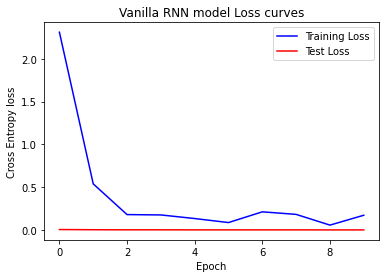

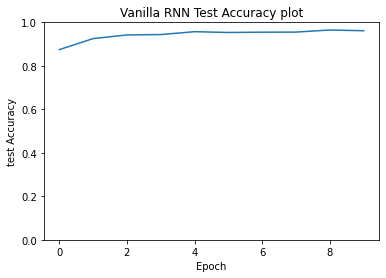



#########################################################################

Average Prediction accuracy of Vanilla RNN model =  94.329


######################################################################

Random Predictions of Vanilla RNN model

True label:4, predicted as 4
True label:2, predicted as 2
True label:4, predicted as 4
True label:1, predicted as 1
True label:4, predicted as 4
True label:7, predicted as 7
True label:8, predicted as 8
True label:8, predicted as 8
True label:7, predicted as 7
True label:7, predicted as 7


In [ ]:
Run_Models(model_cfg="Vanilla RNN", model=vanilla_RNN(input_dim,hidden_dim,num_layers,output_dim).to(device))

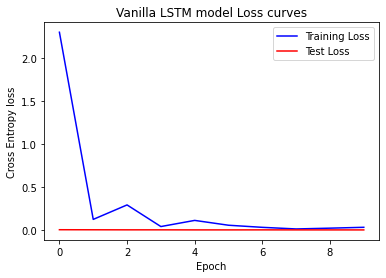

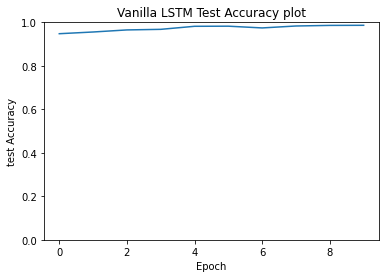



#########################################################################

Average Prediction accuracy of Vanilla LSTM model =  97.31099999999999


######################################################################

Random Predictions of Vanilla LSTM model

True label:1, predicted as 1
True label:2, predicted as 2
True label:9, predicted as 9
True label:6, predicted as 6
True label:4, predicted as 4
True label:0, predicted as 0
True label:9, predicted as 9
True label:0, predicted as 0
True label:8, predicted as 8
True label:3, predicted as 3
vanilla_LSTM(
  (lstm): LSTM(28, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


In [ ]:
Run_Models(model_cfg="Vanilla LSTM", model=vanilla_LSTM(input_dim,hidden_dim,num_layers,output_dim).to(device))

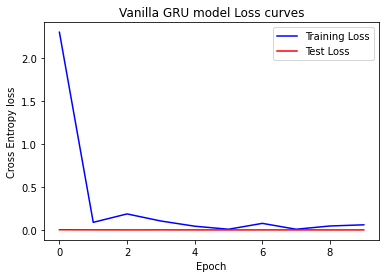

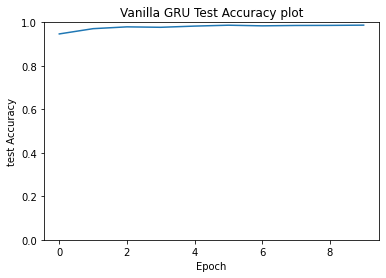



#########################################################################

Average Prediction accuracy of Vanilla GRU model =  97.87099999999998


######################################################################

Random Predictions of Vanilla GRU model

True label:8, predicted as 8
True label:9, predicted as 9
True label:8, predicted as 8
True label:1, predicted as 1
True label:9, predicted as 9
True label:3, predicted as 3
True label:3, predicted as 3
True label:1, predicted as 1
True label:8, predicted as 8
True label:7, predicted as 7
vanilla_GRU(
  (gru): GRU(28, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


In [ ]:
Run_Models(model_cfg="Vanilla GRU", model=vanilla_GRU(input_dim,hidden_dim,num_layers,output_dim).to(device))

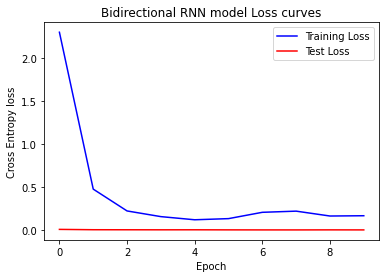

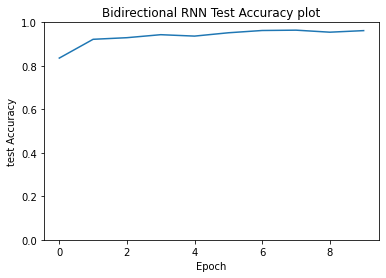



#########################################################################

Average Prediction accuracy of Bidirectional RNN model =  93.63


######################################################################

Random Predictions of Bidirectional RNN model

True label:4, predicted as 4
True label:6, predicted as 6
True label:9, predicted as 9
True label:1, predicted as 1
True label:9, predicted as 9
True label:0, predicted as 0
True label:9, predicted as 9
True label:3, predicted as 3
True label:8, predicted as 8
True label:7, predicted as 7
bidirectional_RNN(
  (rnn): RNN(28, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


In [ ]:
Run_Models(model_cfg="Bidirectional RNN", model=bidirectional_RNN(input_dim,hidden_dim,num_layers,output_dim).to(device))

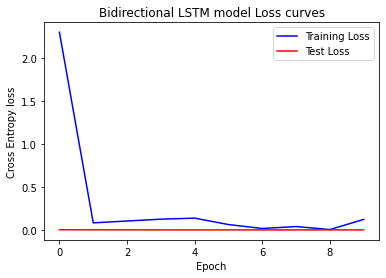

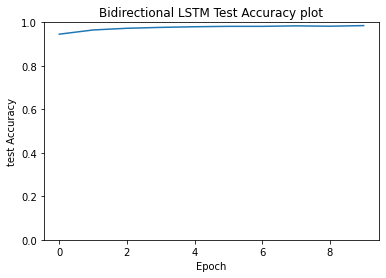



#########################################################################

Average Prediction accuracy of Bidirectional LSTM model =  97.54899999999999


######################################################################

Random Predictions of Bidirectional LSTM model

True label:6, predicted as 6
True label:1, predicted as 1
True label:7, predicted as 7
True label:2, predicted as 2
True label:3, predicted as 3
True label:4, predicted as 4
True label:7, predicted as 7
True label:6, predicted as 6
True label:0, predicted as 0
True label:2, predicted as 2
bidirectional_LSTM(
  (lstm): LSTM(28, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


In [ ]:
Run_Models(model_cfg="Bidirectional LSTM", model=bidirectional_LSTM(input_dim,hidden_dim,num_layers,output_dim).to(device))

# Remembering the number at a particular index in a given sequence

In [ ]:
def sequence_generator(L,batch_size = batch_size,K = 1):
    random_seq = np.random.randint(0, 9,(batch_size, L)) 
    x = np.zeros((batch_size, L,10)) #second dimension is 10 as we're looking at one-hot vectors
    y = np.zeros((batch_size,10)) #output
    for i in range(batch_size):
        x[i,np.arange(L), random_seq[i]] = 1   
        y[i,random_seq[i,K]] = 1  
    random_seq = torch.tensor(random_seq, dtype=torch.int) 
    x = torch.tensor(x, dtype=torch.int)
    y = torch.tensor(y, dtype=torch.int)
    return random_seq,x.float(),y

In [ ]:
def train_random_sequence(model,train_iters,train_losses):
    model.train() 
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_loss    = 0
    train_correct = 0 
    train_length = batch_size*train_iters
    for i in range(train_iters):
        L = np.random.randint(3,10) #chooose a random L value between 3 and 10
        random_seq,x,y = sequence_generator(L)
        # x,y = x.to(device) , y.to(device)
        output = model(x) #prediction using the input data
        loss = Loss_function(output,y.view(output.size()).float())
        optimizer.zero_grad() 
        loss.backward()      
        optimizer.step()     
        
        train_losses.append(loss.item())

In [ ]:
def test_random_sequence(model,test_iters,test_losses,accuracies):
    model.eval() 
    test_loss    = 0
    test_correct = 0 
    test_length = batch_size*test_iters
    with torch.no_grad():
        for i in range(test_iters):
            L = np.random.randint(3,10) #randomizing L
            random_seq,x,y = sequence_generator(L)
            # x,y = x.to(device), y.to(device)
            pred = model(x) 
            loss = Loss_function(pred,y.argmax(axis = 1))
            test_loss    += loss
            # pred=pred.detach().cpu().numpy()
            # y = y.detach().cpu().numpy()
            test_correct += (np.asarray(pred.argmax(axis = 1)-y.argmax(axis = 1))==0).sum() 
    test_correct /= test_length #prediction accuracy 
    test_losses.append(test_loss)
    accuracies.append(test_correct)

In [ ]:
def train_test_random_sequence(model,train_random_sequence_losses,test_random_sequence_losses, test_random_sequence_accuracies):
  for epoch in range(1, 31):
    train_random_sequence(model,train_iters,train_random_sequence_losses)
    test_random_sequence(model,test_iters,test_random_sequence_losses,test_random_sequence_accuracies)

In [ ]:
predictions_iters = 5
def predictions_random_sequence(model,K,predictions_iters = predictions_iters):
    model.eval()  
    with torch.no_grad():
        for i in range(predictions_iters):
            L = np.random.randint(3,10) 
            random_seq,x,y = sequence_generator(L,batch_size = 1,K=K)
            # x,y = x.to(device), y.to(device)
            pred = model(x) #prediction using the input data
            print(f'Generated Sequence:{random_seq}')
            print(f'Predicted Output:{pred.argmax(axis = 1)}')

In [ ]:
train_iters=300
test_iters=60
def Run_random_sequence_Models(model_cfg,model,num_epochs=30):
  train_random_sequence_losses   = []
  test_random_sequence_losses    = []
  test_random_sequence_accuracies  = []
  train_test_random_sequence(model, train_random_sequence_losses, test_random_sequence_losses, test_random_sequence_accuracies)
  # for i in range(len(test_random_sequence_losses)):
  #   test_random_sequence_losses[i] = test_random_sequence_losses[i].cpu().data.numpy()
  plot_function(model_cfg, train_random_sequence_losses , num_epochs, test_random_sequence_losses, test_random_sequence_accuracies)
  print("\n")
  print("#########################################################################\n")
  print(f"Average Prediction accuracy of {model_cfg} model = ",np.mean(test_random_sequence_accuracies)*100)
  print("\n")
  # print("######################################################################\n")
  print(f"Random Predictions of {model_cfg} model\n")
  predictions_random_sequence(model,K=2)
  torch.save(model.state_dict(),model_path+model_cfg)
  


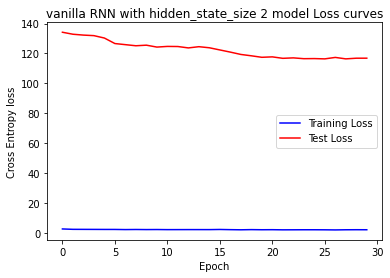

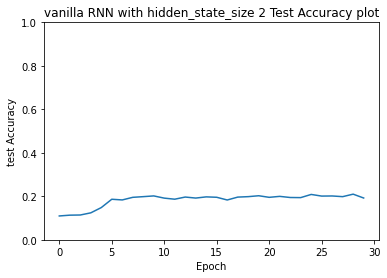



#########################################################################

Average Prediction accuracy of vanilla RNN with hidden_state_size 2 model =  18.3671875


Random Predictions of vanilla RNN with hidden_state_size 2 model

Generated Sequence:tensor([[1, 0, 3]], dtype=torch.int32)
Predicted Output:tensor([1])
Generated Sequence:tensor([[0, 6, 4]], dtype=torch.int32)
Predicted Output:tensor([1])
Generated Sequence:tensor([[0, 4, 2, 0, 0, 1]], dtype=torch.int32)
Predicted Output:tensor([1])
Generated Sequence:tensor([[7, 6, 5, 6, 4, 3, 6, 1, 8]], dtype=torch.int32)
Predicted Output:tensor([1])
Generated Sequence:tensor([[7, 5, 4, 3, 8, 4, 8, 0]], dtype=torch.int32)
Predicted Output:tensor([1])


In [ ]:
device=torch.device("cpu")
Run_random_sequence_Models(model_cfg="vanilla RNN with hidden_state_size 2",model=vanilla_RNN(input_dim=10,hidden_dim=2,num_layers=num_layers,output_dim=10).to(device))

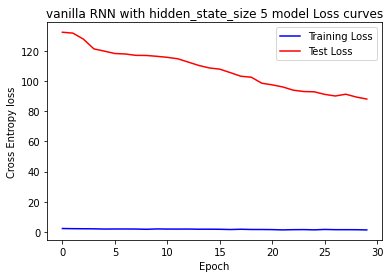

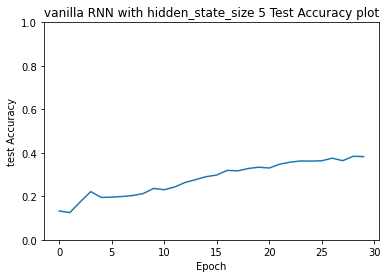



#########################################################################

Average Prediction accuracy of vanilla RNN with hidden_state_size 5 model =  28.085937500000007


Random Predictions of vanilla RNN with hidden_state_size 5 model

Generated Sequence:tensor([[4, 7, 6, 2, 0, 4, 5, 8]], dtype=torch.int32)
Predicted Output:tensor([4])
Generated Sequence:tensor([[0, 5, 4]], dtype=torch.int32)
Predicted Output:tensor([5])
Generated Sequence:tensor([[1, 5, 8, 3, 7, 4, 5]], dtype=torch.int32)
Predicted Output:tensor([5])
Generated Sequence:tensor([[8, 4, 3, 3, 6, 6, 8, 1]], dtype=torch.int32)
Predicted Output:tensor([4])
Generated Sequence:tensor([[5, 4, 7, 6, 3, 4, 1]], dtype=torch.int32)
Predicted Output:tensor([4])


In [ ]:
Run_random_sequence_Models(model_cfg="vanilla RNN with hidden_state_size 5",model=vanilla_RNN(input_dim=10,hidden_dim=5,num_layers=num_layers,output_dim=10).to(device))

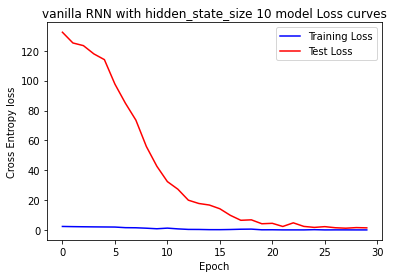

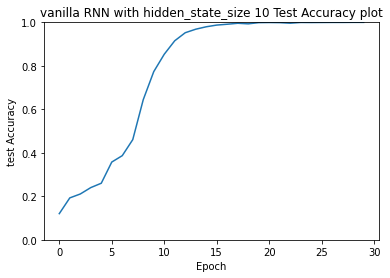



#########################################################################

Average Prediction accuracy of vanilla RNN with hidden_state_size 10 model =  77.58246527777779


Random Predictions of vanilla RNN with hidden_state_size 10 model

Generated Sequence:tensor([[2, 4, 5, 3, 0, 4, 5, 8, 2]], dtype=torch.int32)
Predicted Output:tensor([4])
Generated Sequence:tensor([[5, 1, 7, 7, 6, 4, 3, 3]], dtype=torch.int32)
Predicted Output:tensor([1])
Generated Sequence:tensor([[1, 1, 4, 5, 3]], dtype=torch.int32)
Predicted Output:tensor([1])
Generated Sequence:tensor([[3, 0, 7, 4, 7]], dtype=torch.int32)
Predicted Output:tensor([0])
Generated Sequence:tensor([[2, 7, 2, 7, 0, 7, 4]], dtype=torch.int32)
Predicted Output:tensor([7])


In [ ]:
Run_random_sequence_Models(model_cfg="vanilla RNN with hidden_state_size 10",model=vanilla_RNN(input_dim=10,hidden_dim=10,num_layers=num_layers,output_dim=10).to(device))

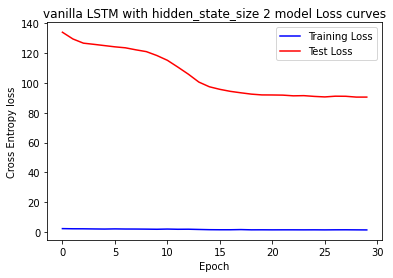

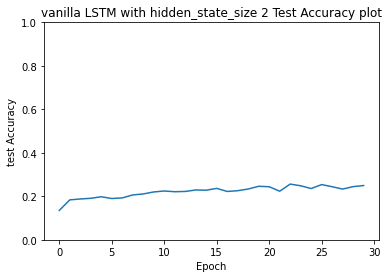



#########################################################################

Average Prediction accuracy of vanilla LSTM with hidden_state_size 2 model =  22.12586805555555


Random Predictions of vanilla LSTM with hidden_state_size 2 model

Generated Sequence:tensor([[4, 3, 2, 4, 1, 6, 7, 8]], dtype=torch.int32)
Predicted Output:tensor([7])
Generated Sequence:tensor([[3, 4, 4, 4, 1, 8]], dtype=torch.int32)
Predicted Output:tensor([7])
Generated Sequence:tensor([[1, 7, 2, 4, 3, 1]], dtype=torch.int32)
Predicted Output:tensor([7])
Generated Sequence:tensor([[2, 1, 8, 5, 6, 6, 1]], dtype=torch.int32)
Predicted Output:tensor([0])
Generated Sequence:tensor([[8, 1, 8]], dtype=torch.int32)
Predicted Output:tensor([6])


In [ ]:
Run_random_sequence_Models(model_cfg="vanilla LSTM with hidden_state_size 2",model=vanilla_LSTM(input_dim=10,hidden_dim=2,num_layers=num_layers,output_dim=10).to(device))

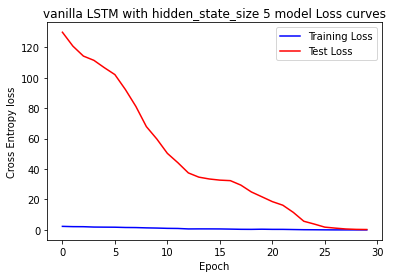

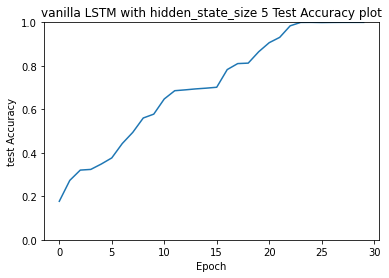



#########################################################################

Average Prediction accuracy of vanilla LSTM with hidden_state_size 5 model =  70.33680555555556


Random Predictions of vanilla LSTM with hidden_state_size 5 model

Generated Sequence:tensor([[2, 4, 4]], dtype=torch.int32)
Predicted Output:tensor([4])
Generated Sequence:tensor([[6, 8, 2, 4, 1, 5, 0, 5, 2]], dtype=torch.int32)
Predicted Output:tensor([8])
Generated Sequence:tensor([[7, 0, 3, 5, 4, 2]], dtype=torch.int32)
Predicted Output:tensor([0])
Generated Sequence:tensor([[7, 6, 0, 0, 8, 1, 2, 7]], dtype=torch.int32)
Predicted Output:tensor([6])
Generated Sequence:tensor([[8, 6, 3, 6, 4, 8]], dtype=torch.int32)
Predicted Output:tensor([6])


In [ ]:
Run_random_sequence_Models(model_cfg="vanilla LSTM with hidden_state_size 5",model=vanilla_LSTM(input_dim=10,hidden_dim=5,num_layers=num_layers,output_dim=10).to(device))

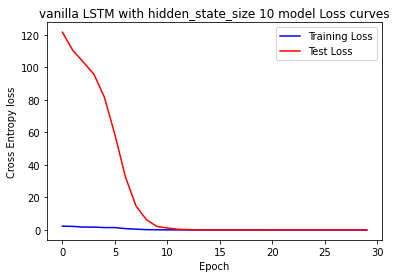

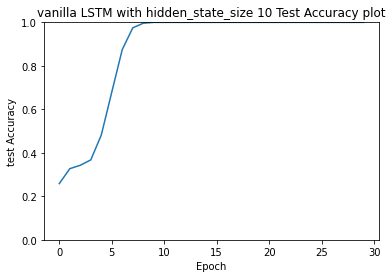



#########################################################################

Average Prediction accuracy of vanilla LSTM with hidden_state_size 10 model =  87.67361111111111


Random Predictions of vanilla LSTM with hidden_state_size 10 model

Generated Sequence:tensor([[6, 4, 4, 7, 4]], dtype=torch.int32)
Predicted Output:tensor([4])
Generated Sequence:tensor([[2, 7, 4, 7, 0]], dtype=torch.int32)
Predicted Output:tensor([7])
Generated Sequence:tensor([[5, 4, 5, 3, 5, 1]], dtype=torch.int32)
Predicted Output:tensor([4])
Generated Sequence:tensor([[6, 5, 3, 1, 4, 2]], dtype=torch.int32)
Predicted Output:tensor([5])
Generated Sequence:tensor([[0, 5, 6, 5, 5, 1, 0, 1, 0]], dtype=torch.int32)
Predicted Output:tensor([5])


In [ ]:
Run_random_sequence_Models(model_cfg="vanilla LSTM with hidden_state_size 10",model=vanilla_LSTM(input_dim=10,hidden_dim=10,num_layers=num_layers,output_dim=10).to(device))

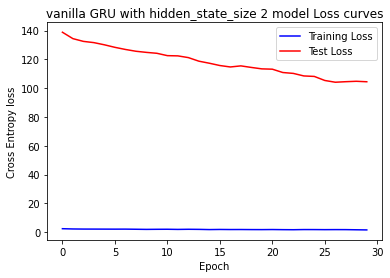

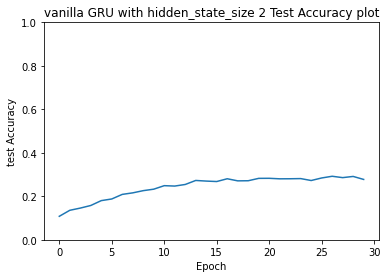



#########################################################################

Average Prediction accuracy of vanilla GRU with hidden_state_size 2 model =  24.320312499999996


Random Predictions of vanilla GRU with hidden_state_size 2 model

Generated Sequence:tensor([[6, 1, 6, 0]], dtype=torch.int32)
Predicted Output:tensor([1])
Generated Sequence:tensor([[8, 0, 3, 3, 8, 3]], dtype=torch.int32)
Predicted Output:tensor([8])
Generated Sequence:tensor([[0, 6, 2, 2]], dtype=torch.int32)
Predicted Output:tensor([1])
Generated Sequence:tensor([[7, 7, 2]], dtype=torch.int32)
Predicted Output:tensor([1])
Generated Sequence:tensor([[7, 1, 2, 0, 1, 7, 1]], dtype=torch.int32)
Predicted Output:tensor([1])


In [ ]:
Run_random_sequence_Models(model_cfg="vanilla GRU with hidden_state_size 2",model=vanilla_GRU(input_dim=10,hidden_dim=2,num_layers=num_layers,output_dim=10).to(device))

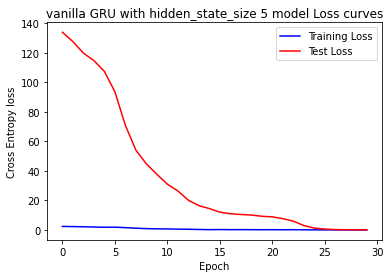

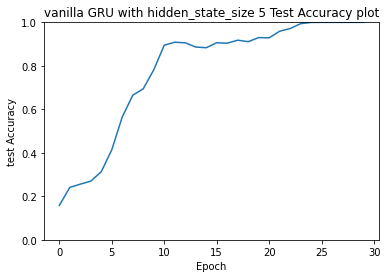



#########################################################################

Average Prediction accuracy of vanilla GRU with hidden_state_size 5 model =  77.53385416666666


Random Predictions of vanilla GRU with hidden_state_size 5 model

Generated Sequence:tensor([[1, 0, 4, 3]], dtype=torch.int32)
Predicted Output:tensor([0])
Generated Sequence:tensor([[4, 2, 5, 5]], dtype=torch.int32)
Predicted Output:tensor([2])
Generated Sequence:tensor([[7, 5, 5]], dtype=torch.int32)
Predicted Output:tensor([5])
Generated Sequence:tensor([[2, 3, 2]], dtype=torch.int32)
Predicted Output:tensor([3])
Generated Sequence:tensor([[0, 0, 1, 8, 0]], dtype=torch.int32)
Predicted Output:tensor([0])


In [ ]:
Run_random_sequence_Models(model_cfg="vanilla GRU with hidden_state_size 5",model=vanilla_GRU(input_dim=10,hidden_dim=5,num_layers=num_layers,output_dim=10).to(device))

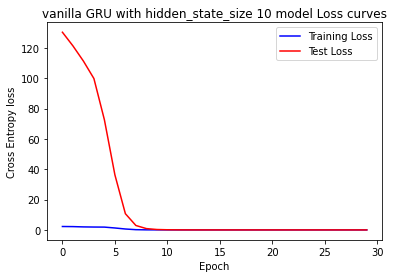

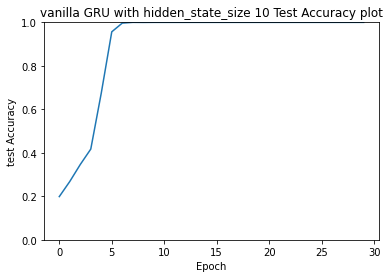



#########################################################################

Average Prediction accuracy of vanilla GRU with hidden_state_size 10 model =  89.52690972222221


Random Predictions of vanilla GRU with hidden_state_size 10 model

Generated Sequence:tensor([[7, 6, 6]], dtype=torch.int32)
Predicted Output:tensor([6])
Generated Sequence:tensor([[7, 1, 0, 6, 1, 6, 7, 2]], dtype=torch.int32)
Predicted Output:tensor([1])
Generated Sequence:tensor([[6, 0, 6]], dtype=torch.int32)
Predicted Output:tensor([0])
Generated Sequence:tensor([[4, 1, 1, 4, 3, 1, 7, 6]], dtype=torch.int32)
Predicted Output:tensor([1])
Generated Sequence:tensor([[8, 5, 8, 5, 7, 7, 3, 0]], dtype=torch.int32)
Predicted Output:tensor([5])


In [ ]:
Run_random_sequence_Models(model_cfg="vanilla GRU with hidden_state_size 10",model=vanilla_GRU(input_dim=10,hidden_dim=10,num_layers=num_layers,output_dim=10).to(device))

# Binary Addition using RNN LSTM Model

In [ ]:
class Binary_LSTM(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, num_layers=1):
        super(Binary_LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,bidirectional=False)
        self.fc = nn.Linear(hidden_dim,1) #as size of the output is 1
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x): 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        pred   = self.sigmoid(self.fc(out)) #output at every time step
        return pred

In [ ]:
def binary_sequence_generator(L,batch_size = batch_size):
    x = np.zeros((batch_size, L+1 ,2)) #zero padding as sum of sequence may have dimension L+1
    y = np.zeros((batch_size,L+1)) #output

    for i in range(batch_size):
        a = np.random.randint(0,2**(L)) #number 1
        b = np.random.randint(0,2**L) #number 2
        c = a+b #sum
  
        bin_a = bin(a)[2:]
        bin_a = list(str('0')*(L+1 - len(bin_a)) + bin_a) #sign extension
        bin_a = np.asarray(bin_a[::-1],dtype = int) #converting to numpy array and reversing the string
        
        bin_b = bin(b)[2:]
        bin_b = list(str('0')*(L+1 - len(bin_b)) + bin_b) #sign extension
        bin_b = np.asarray(bin_b[::-1],dtype = int) #converting to numpy array and reversing the string
                
        bin_c = bin(c)[2:]
        bin_c = list(str('0')*(L+1 - len(bin_c)) + bin_c) #sign extension
        bin_c = np.asarray(bin_c[::-1],dtype = int) #converting to numpy array and reversing the string
        
        x[i,:,0] = bin_a
        x[i,:,1] = bin_b
        y[i]     = bin_c
        
    x = torch.tensor(x, dtype=torch.int)
    y = torch.tensor(y, dtype=torch.int)

    return x.float(),y 

In [ ]:
def train_binary_sequence(model,train_iters,train_losses,loss_flag = 1,L=3): #loss_flag = 1 for MSE and 0 for CE
  
  model.train() 
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_loss    = 0
  train_correct = 0 
  train_length = batch_size*train_iters
  for i in range(train_iters):
      x,y = binary_sequence_generator(L)
      # x,y = x.to(device), y.to(device)
      pred = model(x) 
      if(loss_flag == 0): #CE Loss
          loss = Loss_function(pred,y.view(pred.size()).float())
      elif(loss_flag == 1): #MSE Loss
          loss_fn = nn.MSELoss()
          loss = loss_fn(pred,y.view(pred.size()).float()) 
      optimizer.zero_grad() 
      loss.backward()      
      optimizer.step()      
      
      #prediction made by LSTM
      threshold = torch.Tensor([0.5])
      pred_y = (pred > threshold).float() * 1
      
      #converting to base 10 equivalent
      pred_y = pred_y.numpy()[:,:,0]
      pred_y = pred_y.dot(2**np.arange(pred_y.shape[1]))

      y_10 = y.numpy()
      y_10 = y_10.dot(2**np.arange(y_10.shape[1]))

      train_losses.append(loss.item())

In [ ]:
def test_binary_sequence(model,test_losses,accuracies,test_iters,loss_flag = 1,L = 3): #as we're supposed to test on 100 samples
    
    model.eval()  
    test_loss    = 0
    test_correct = 0 
    test_length = batch_size*test_iters
    with torch.no_grad():
        for i in range(test_iters):
            x,y = binary_sequence_generator(L)
            pred = model(x.float()) 
            if(loss_flag == 0): #CE Loss
                loss = Loss_function(pred,y.view(pred.size()).float())
            elif(loss_flag == 1): #MSE Loss
                loss_fn = nn.MSELoss()
                loss = loss_fn(pred,y.view(pred.size()).float())    
                        
            #prediction made by LSTM
            threshold = torch.Tensor([0.5])
            pred_y = (pred > threshold).float() * 1
            
            #converting to base 10 equivalent
            pred_y = pred_y.numpy()[:,:,0]
            pred_y = pred_y.dot(2**np.arange(pred_y.shape[1]))

            y_10 = y.numpy()
            y_10 = y_10.dot(2**np.arange(y_10.shape[1]))

            test_loss    += loss
            test_correct += np.sum(pred_y==y_10) 
    
    test_correct /= test_length #prediction accuracy 
    test_losses.append(test_loss)
    accuracies.append(test_correct)    

In [ ]:
num_epochs = 10
def train_test_binary_sequence(model,train_binary_sequence_losses,test_binary_sequence_losses, test_binary_sequence_accuracies,loss_flag):
  for epoch in range(1, num_epochs+1):
    train_binary_sequence(model,train_iters,train_binary_sequence_losses,loss_flag,L=3)
    test_binary_sequence(model,test_binary_sequence_losses,test_binary_sequence_accuracies,test_iters=test_iters,loss_flag=loss_flag,L=3)

In [ ]:
def plot_function_binary_sequence(model_cfg,train_losses,num_epochs, test_losses, test_accuracies,loss_flag):
  # Plotting the Train loss 
  interval = int(len(train_losses)/num_epochs)
  plt.title(f"{model_cfg} model Loss curves")
  plt.xlabel("Epoch")
  if loss_flag==0:
    plt.ylabel("Cross Entropy loss")
  elif loss_flag == 1:
    plt.ylabel("MSE loss")
  plt.plot(np.asarray(train_losses)[::interval],'b')
  plt.plot(np.asarray(test_losses),'r')
  plt.legend(["Training Loss", "Test Loss"])
  plt.show()

  #plotting the Test accuracy
  plt.plot(np.asarray(test_accuracies))
  plt.title(f"{model_cfg} Test Accuracy plot")
  plt.xlabel("Epoch")
  plt.ylabel("test Accuracy")
  plt.ylim(0,1)
  plt.show()


In [ ]:
train_iters=300
test_iters=60
def Run_binary_sequence_Models(model_cfg,model,loss_flag,num_epochs=num_epochs):
  train_binary_sequence_losses   = []
  test_binary_sequence_losses    = []
  test_binary_sequence_accuracies  = []
  train_test_binary_sequence(model,train_binary_sequence_losses,test_binary_sequence_losses, test_binary_sequence_accuracies,loss_flag)
  # for i in range(len(test_random_sequence_losses)):
  #   test_random_sequence_losses[i] = test_random_sequence_losses[i].cpu().data.numpy()
  plot_function_binary_sequence(model_cfg, train_binary_sequence_losses , num_epochs, test_binary_sequence_losses, test_binary_sequence_accuracies,loss_flag)
  print("\n")
  print("#########################################################################\n")
  print(f'Prediction Accuracies : {test_binary_sequence_accuracies}\n')
  print("######################################################################\n")
  print(f"Average Prediction accuracy of {model_cfg} model = ",np.mean(test_binary_sequence_accuracies)*100)
  print("\n")
  # torch.save(model.state_dict(),model_path+model_cfg)


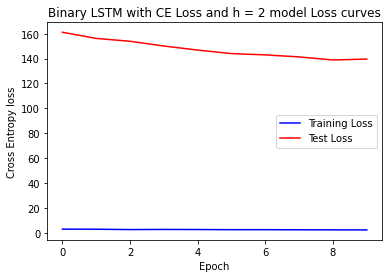

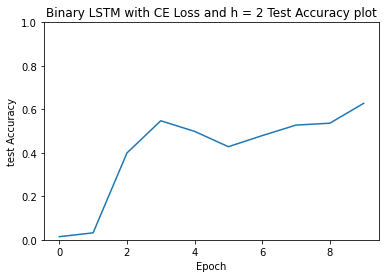



#########################################################################

Prediction Accuracies : [0.014322916666666666, 0.03203125, 0.39921875, 0.5473958333333333, 0.4986979166666667, 0.428125, 0.4791666666666667, 0.5276041666666667, 0.5361979166666667, 0.6276041666666666]

######################################################################

Average Prediction accuracy of Binary LSTM with CE Loss and h = 2 model =  40.903645833333336




In [ ]:
Run_binary_sequence_Models(model_cfg="Binary LSTM with CE Loss and h = 2",model=Binary_LSTM(input_dim=2,hidden_dim=2,num_layers=num_layers).to(device), loss_flag=0)

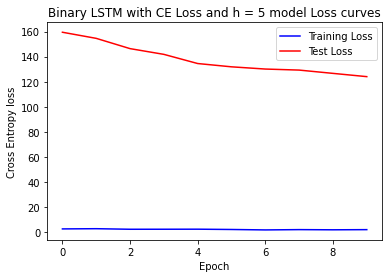

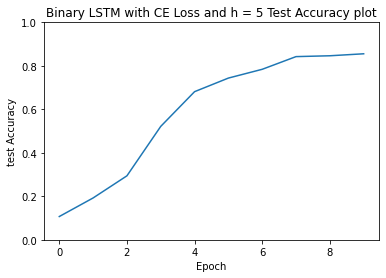



#########################################################################

Prediction Accuracies : [0.10703125, 0.19244791666666666, 0.2942708333333333, 0.5216145833333333, 0.68125, 0.74375, 0.7841145833333333, 0.8424479166666666, 0.8463541666666666, 0.85546875]

######################################################################

Average Prediction accuracy of Binary LSTM with CE Loss and h = 5 model =  58.6875




In [ ]:
Run_binary_sequence_Models(model_cfg="Binary LSTM with CE Loss and h = 5",model=Binary_LSTM(input_dim=2,hidden_dim=5,num_layers=num_layers).to(device), loss_flag=0)

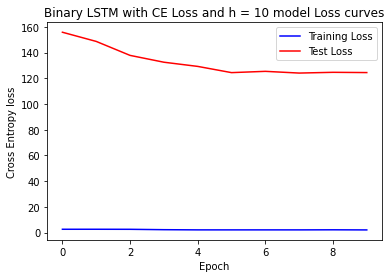

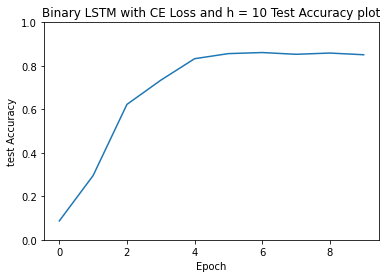



#########################################################################

Prediction Accuracies : [0.08671875, 0.2953125, 0.62265625, 0.7338541666666667, 0.8328125, 0.85625, 0.8611979166666667, 0.853125, 0.8588541666666667, 0.8510416666666667]

######################################################################

Average Prediction accuracy of Binary LSTM with CE Loss and h = 10 model =  68.51822916666667




In [ ]:
Run_binary_sequence_Models(model_cfg="Binary LSTM with CE Loss and h = 10",model=Binary_LSTM(input_dim=2,hidden_dim=10,num_layers=num_layers).to(device), loss_flag=0)

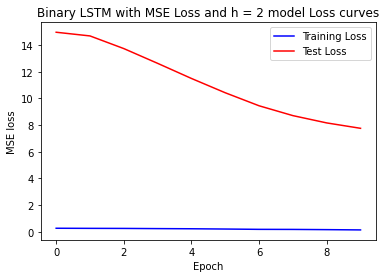

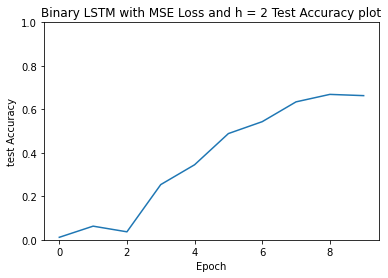



#########################################################################

Prediction Accuracies : [0.011458333333333333, 0.06276041666666667, 0.03671875, 0.25390625, 0.3450520833333333, 0.48854166666666665, 0.5432291666666667, 0.634375, 0.66875, 0.6630208333333333]

######################################################################

Average Prediction accuracy of Binary LSTM with MSE Loss and h = 2 model =  37.078125




In [ ]:
Run_binary_sequence_Models(model_cfg="Binary LSTM with MSE Loss and h = 2",model=Binary_LSTM(input_dim=2,hidden_dim=2,num_layers=num_layers).to(device), loss_flag=1)

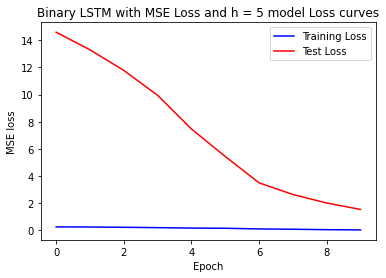

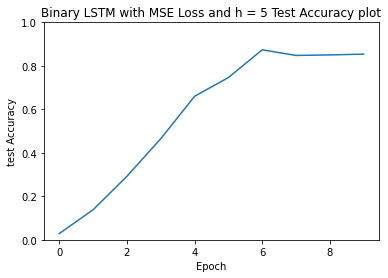



#########################################################################

Prediction Accuracies : [0.028645833333333332, 0.13828125, 0.2921875, 0.46484375, 0.6598958333333333, 0.74609375, 0.8736979166666666, 0.8479166666666667, 0.8502604166666666, 0.85390625]

######################################################################

Average Prediction accuracy of Binary LSTM with MSE Loss and h = 5 model =  57.557291666666664




In [ ]:
Run_binary_sequence_Models(model_cfg="Binary LSTM with MSE Loss and h = 5",model=Binary_LSTM(input_dim=2,hidden_dim=5,num_layers=num_layers).to(device), loss_flag=1)

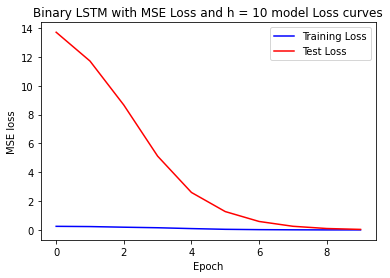

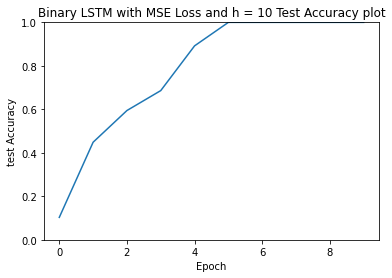



#########################################################################

Prediction Accuracies : [0.103125, 0.44869791666666664, 0.59453125, 0.6861979166666666, 0.8919270833333334, 1.0, 1.0, 1.0, 1.0, 1.0]

######################################################################

Average Prediction accuracy of Binary LSTM with MSE Loss and h = 10 model =  77.24479166666667




In [ ]:
Run_binary_sequence_Models(model_cfg="Binary LSTM with MSE Loss and h = 10",model=Binary_LSTM(input_dim=2,hidden_dim=10,num_layers=num_layers).to(device), loss_flag=1)